In [1]:
import numpy as np
import struct

In [220]:
file_path = "./storage/rx_sync_data.dat"
sample_size = 8
with open(file_path, 'rb') as f:
    # Read the binary data
    binary_data = f.read()

num_samples = len(binary_data) // sample_size
samples = []
for i in range(num_samples):
    # Extract real and imaginary parts from the binary data
    real_part, imag_part = struct.unpack('ff', binary_data[i * sample_size: (i + 1) * sample_size])
    # Create a complex number and append it to the list of samples
    samples.append(complex(real_part, imag_part))

samples = np.array(samples)
samples.shape

(15315,)

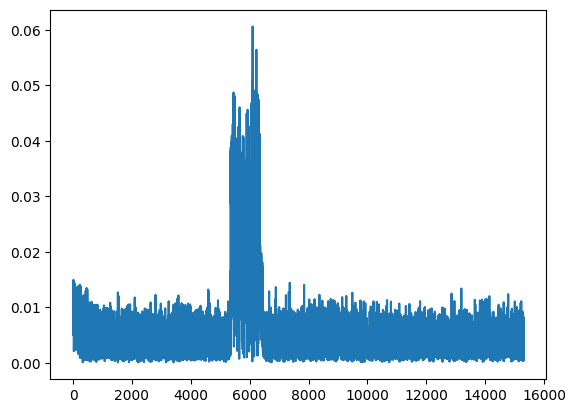

In [221]:
from matplotlib import pyplot as plt
plt.plot(np.abs(samples))

In [222]:
N = 1021
M = 31
R = 1
zfc_seq = np.array([np.exp(-1j * np.pi * M * n * (n + 1) / N) for n in range(N)])
# zfc_seq_rep = np.tile(zfc_seq, R)
print(zfc_seq.shape)
# print(zfc_seq_rep.shape)

(1021,)


6467


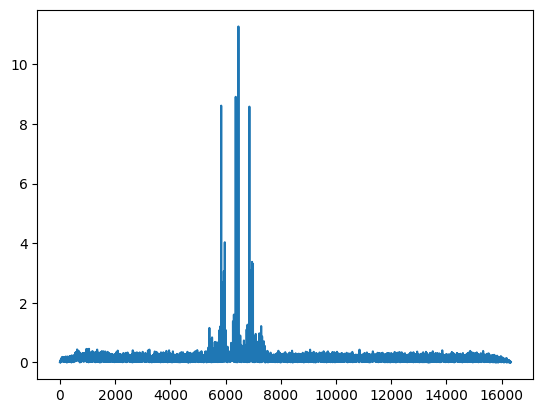

In [223]:
corr_zfc = np.correlate(samples, zfc_seq, mode='full')
plt.plot(np.abs(corr_zfc))
print(np.argmax(np.abs(corr_zfc)))

[5843 6369 6467 6864]
[ 8.614265    8.90987178 11.26978553  8.58132945]


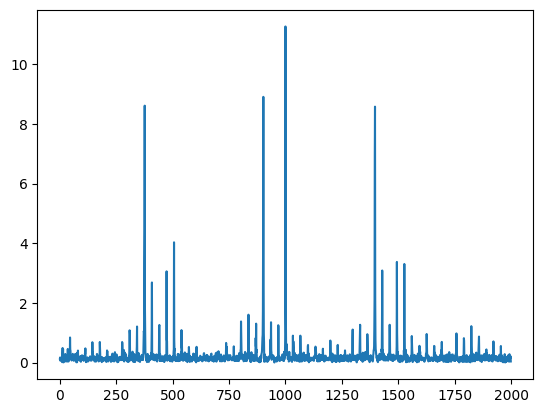

In [228]:
plot_data = np.abs(corr_zfc)
pmax = np.argmax(plot_data).item()

plt.plot(plot_data[pmax - 1000 : pmax + 1000])

print(np.argwhere(plot_data > 8.0).squeeze())
print(plot_data[np.argwhere(plot_data > 8.0).squeeze()])
